## Compare oil type volumes by vessel 

In [1]:
import pandas 
import numpy as np
import matplotlib.pyplot as plt
import yaml
from pathlib import Path

# import functions for querying DOE and monte-carlo dataframes
from monte_carlo_utils import get_montecarlo_oilexport
from monte_carlo_utils import get_oil_classification
from monte_carlo_utils import get_DOE_exports

In [2]:
#~~~~~  User inputs ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Dept. of Ecology data files
DOE_dir  = Path('/Users/rmueller/Data/MIDOSS/DeptOfEcology/')
DOE_2018_xlsx = DOE_dir/'MuellerTrans4-30-20.xlsx'
DOE_2021_xlsx = DOE_dir/'MuellerTrans_5-26-21.xlsx'

data_types    = ['total_gallons', 'fraction_of_total', 'number_of_transfers']
# oil types used in our study
oil_types = [
    'ANS','Bunker-C','Diesel','Gasoline','Jet Fuel', 'Dilbit', 'Other'
]
oil_colors = [
    'orange', 'saddlebrown','darkslateblue',
    'steelblue','slateblue','olive',
    'darkgoldenrod'
]
# create a color dictionary for oil types to us in pie charts
colordict={}
for l,c in zip(oil_types,oil_colors):
    colordict[l]=c

# 10,000 monte carlo spills
#monte_carlo_csv = '/Users/rmueller/Data/MIDOSS/monte_carlo/SalishSeaOilSpills_fixbarge_10000.csv'
#monte_carlo_csv = '/Users/rmueller/Data/MIDOSS/monte_carlo/SalishSeaSpills_10000_adjustbargecargo.csv'
monte_carlo_csv = '/Users/rmueller/Data/MIDOSS/monte_carlo/SalishSeaOilSpills_fixbarge_10000_1.csv'

# Load Oil Attribution file 
oil_attribution_file = '/Users/rmueller/Data/MIDOSS/marine_transport_data/oil_attribution.yaml'

with open(oil_attribution_file) as file:
        oil_attrs = yaml.load(file, Loader=yaml.Loader)

# location of output excel spreadsheets
output_directory = Path('/Users/rmueller/Data/MIDOSS/DeptOfEcology/')
graphics_directory = Path(
    '/Users/rmueller/Projects/MIDOSS/graphics_figures/monte_carlo'
)

# The precision used to calculate oil type weights 
# Trial and error showed that a precision of 2 is neccessary for weights
# to sum to 1.0
precision = 2

# unit conversions
gal2m3 = 0.00378541

# facility names

# The following list includes facilities used in Casey's origin/destination 
# analysis with names matching the Dept. of Ecology (DOE) database.  
# For example, the shapefile "Maxum Petroleum - Harbor Island Terminal" is 
# labeled as 'Maxum (Rainer Petroleum)' in the DOE database.  I use the 
# Ecology language here and will need to translate to Shapefile speak

# Terminals that are grouped in voyage joins are removed, e.g.:
# 'Maxum (Rainer Petroleum)' and 'Shell Oil LP Seattle Distribution Terminal' 
# are represented in
#  ==>'Kinder Morgan Liquids Terminal - Harbor Island' 
# 'Nustar Energy Tacoma' => 'Phillips 66 Tacoma Terminal'
facility_names = [ 
    'BP Cherry Point Refinery', 'Shell Puget Sound Refinery', 
    'Tidewater Snake River Terminal', 'SeaPort Sound Terminal', 
    'Tesoro Vancouver Terminal', 'Phillips 66 Ferndale Refinery', 
    'Phillips 66 Tacoma Terminal', 
    'Andeavor Anacortes Refinery (formerly Tesoro)',
    'Tesoro Port Angeles Terminal','U.S. Oil & Refining',
    'Naval Air Station Whidbey Island (NASWI)',
    'NAVSUP Manchester', 'Alon Asphalt Company (Paramount Petroleum)', 
    'Kinder Morgan Liquids Terminal - Harbor Island' ,  
    'Tesoro Pasco Terminal', 'REG Grays Harbor, LLC', 
    'Tidewater Vancouver Terminal','TLP Management Services LLC (TMS)'
]


---
## Plot monte carlo and DOE representation of oil exports by vessel types
---

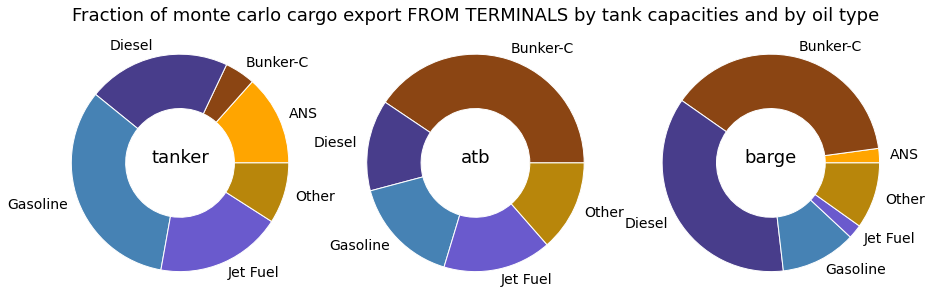

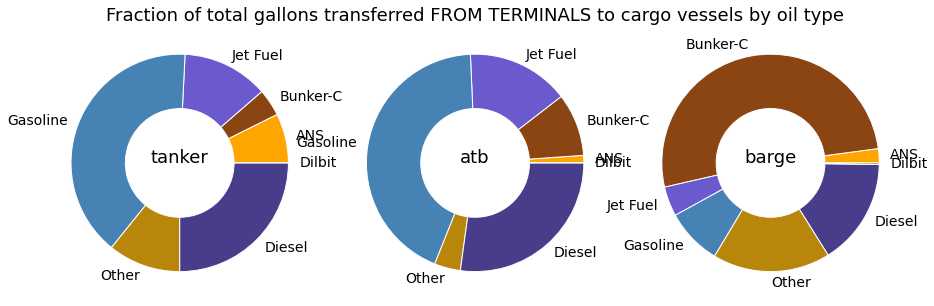

In [3]:
#--------------------------------------------------------------------------------
# Plot monte-carlo representation of oil export 
#--------------------------------------------------------------------------------
# Get cargo exports by vessel type and add up cargo_capacities by oil type

fig, axes = plt.subplots(1, 3, figsize = (15,5))
for idx,vessel in enumerate(["tanker","atb","barge"]):
    # calculate total cargo_capacity by vessel type and oil type
    total_capacity = get_montecarlo_oilexport(
        vessel, 
        monte_carlo_csv
    )
    # add central title
    axes[idx].axis('equal') 
    if idx==1:
        axes[idx].set_title(
            f'Fraction of monte carlo cargo export FROM TERMINALS by tank capacities and by oil type',
            fontsize=18
        )
    # plot up results
    pie_wedge_collection  = axes[idx].pie(
        total_capacity, 
        labels = total_capacity.index.to_list(),
        wedgeprops=dict(width=0.5),
        textprops={'fontsize': 14}
    )
    # make colors uniform across subplots
    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
        
    axes[idx].axis('off')
    axes[idx].text(0,0,vessel,ha='center',fontsize=18)
plt.savefig(graphics_directory/'monte_carlo_oil_exports_v2')

#--------------------------------------------------------------------------------
## Plot department of ecology volume transfers from marine terminals by oil types
#--------------------------------------------------------------------------------
exports = get_DOE_exports(
    DOE_2018_xlsx, facilities='selected'
)

# Adjust dictionary keys to reflect graphing labels rather than monte-carlo 
# code labels
for vessel in ['tanker','atb','barge']:
    exports[vessel]['ANS'] = exports[vessel]['akns']
    exports[vessel]['Bunker-C'] = exports[vessel]['bunker']
    exports[vessel]['Jet Fuel'] = exports[vessel]['jet']
    exports[vessel]['Gasoline'] = exports[vessel]['gas']
    exports[vessel]['Other'] = exports[vessel]['other']
    exports[vessel]['Diesel'] = exports[vessel]['diesel']
    exports[vessel]['Dilbit'] = exports[vessel]['dilbit']
    exports[vessel].pop('akns')
    exports[vessel].pop('bunker')
    exports[vessel].pop('jet')
    exports[vessel].pop('gas')
    exports[vessel].pop('other')
    exports[vessel].pop('diesel')
    exports[vessel].pop('dilbit')
    
fig, axes = plt.subplots(1, 3, figsize = (15,5))
for idx,vessel in enumerate(["tanker","atb","barge",]):
    # calculate total cargo_capacity by vessel type and oil type
    net_export = exports[vessel].values()
    # add central title
    axes[idx].axis('equal') 
    if idx==1:
        axes[idx].set_title(
            f'Fraction of total gallons transferred FROM TERMINALS to cargo vessels by oil type',
            fontsize=18
        )
    # plot up results
    pie_wedge_collection  = axes[idx].pie(
        net_export, 
        labels = exports['atb'].keys(),
        wedgeprops=dict(width=0.5),
        textprops={'fontsize': 14}
    )
    # make colors uniform across subplots
    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
        
    axes[idx].axis('off')
    axes[idx].text(0,0,vessel,ha='center',fontsize=18)
plt.savefig(graphics_directory/'DOE_oil_exports_byterminals')

## Take aways:
- We do tanker exports reasonably well. :-) 
- We do jet fuel reasonably well for all vessel
- We tend to get Bunker-C right for tanker and barges
- We show Bunker as the dominant ATB export where DOE shows gasoline (We under attribute gasoline and over-attribute bunker-C in atbs)
- We show less Bunker-C in barge export and more deisel than DOE barge export 

Plausible explanations: 
- Our vessel join method is biased in which terminals it captures. 
- Barge tugs may be attributed as ATB tugs and visa versa (hence, attributed differently in our attribution than in DOE data)     

### NEXT: 
- Plot up all cargo transfers and all cargo oil in monte carlo (both terminal and non-terminal transfrrs)
- Plot up combined imports and exports to terminals
